In [2]:

from data import load_all_data
dataset = load_all_data()

print(dataset)

number of dates: 2868
The dataset has 70 features, each feature has 2868 data points
DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 70
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 70
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 70
    })
})


In [3]:
freq = "1D"
prediction_length = 365

train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [4]:

from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [5]:

from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


from gluonts.dataset.multivariate_grouper import MultivariateGrouper
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)
print(multi_variate_train_dataset[0]["target"])


[[1.624695e+00 1.625250e+00 1.608234e+00 ... 1.389043e+00 1.393146e+00
  1.398993e+00]
 [1.230900e+00 1.232500e+00 1.234300e+00 ... 1.167260e+00 1.168100e+00
  1.167290e+00]
 [5.000000e-01 5.000000e-01 5.000000e-01 ... 1.000000e-01 1.000000e-01
  1.000000e-01]
 ...
 [0.000000e+00 0.000000e+00 0.000000e+00 ... 5.863020e+05 5.863020e+05
  6.007500e+05]
 [3.290200e+02 3.668200e+02 2.879000e+02 ... 1.953300e+02 2.752400e+02
  1.067100e+02]
 [1.005860e+03 5.270200e+02 4.190400e+02 ... 4.525000e+02 5.484400e+02
  3.160400e+02]]


In [6]:

from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]
[<function day_of_week at 0x7f88ac0c8670>, <function day_of_month at 0x7f88ac0c8790>, <function day_of_year at 0x7f88ac0c88b0>]


In [7]:

from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

In [8]:

model = InformerForPrediction(config)

from dataloader import create_train_dataloader, create_backtest_dataloader
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

In [9]:

### Train the model! ###
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 30
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-5, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())


-63.878639221191406
-96.02436065673828
-118.99098205566406
-116.18824005126953
-143.72886657714844
-139.45989990234375
-128.63226318359375
-154.1968536376953
-153.25344848632812
-172.9629364013672
-149.3276824951172
-178.05856323242188
-170.65609741210938
-198.41851806640625
-212.39808654785156
-198.51153564453125
-193.7654571533203
-211.01199340820312
-219.2396697998047
-178.66062927246094
-212.63145446777344
-218.78073120117188
-216.16299438476562
-199.72622680664062
-230.4520263671875
-212.8234100341797
-224.3458251953125
-229.00079345703125
-230.26126098632812
-243.27601623535156


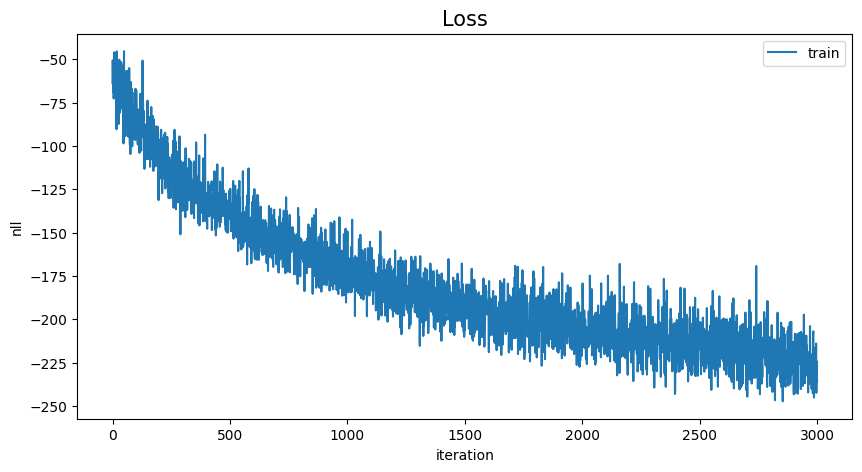

In [10]:

import matplotlib.pyplot as plt
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.savefig("./train.png")
plt.show()


In [11]:

# perform inference
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

print(forecasts_[0].shape)
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 365, 70)
(1, 100, 365, 70)


In [15]:
# perform evaluate
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts,1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

ValueError: Input contains NaN.

: 

In [91]:

df = pd.read_excel('all_data.xlsx', usecols=['Date'])
dates = pd.to_datetime(df['Date'])
dates

0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]

In [92]:

import matplotlib.dates as mdates
from gluonts.dataset.field_names import FieldName


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = dates
    print(f"index is {index}")
    print(f"length of index: {len(index)}")

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[:-prediction_length],
        multi_variate_test_dataset[ts_index]["target"][mv_index,:],
        label="actual",
    )

    ax.plot(
        index[-2*prediction_length:-prediction_length],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-2*prediction_length:-prediction_length],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()
    return fig, ax

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


Text(0, 0.5, 'GBP_USD')

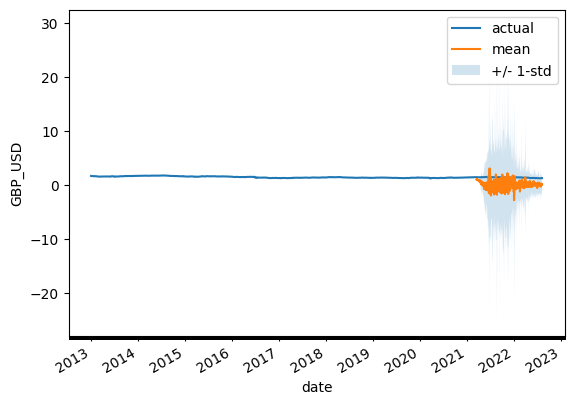

In [93]:
fig, ax = plot(0,0)
ax.set_xlabel('date')
ax.set_ylabel('GBP_USD')

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


Text(0, 0.5, 'GBP_EUR')

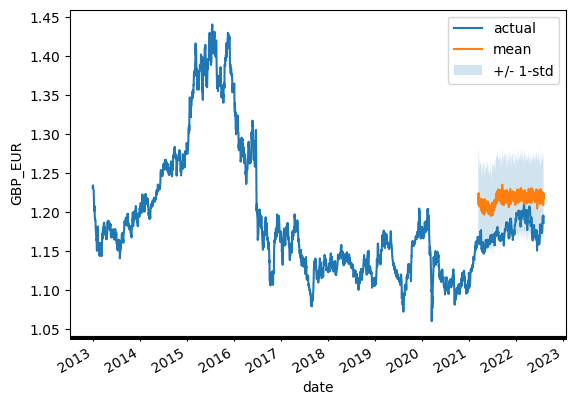

In [42]:
fig, ax = plot(0,1)
ax.set_xlabel('date')
ax.set_ylabel('GBP_EUR')